<a href="https://colab.research.google.com/github/mikemcgilly/NFL/blob/main/ShotgunVsUnderCenterYPCMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#setup
%%capture
%pip install nfl_data_py --upgrade
import nfl_data_py as nfl
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
#import data
all_data = nfl.import_pbp_data([2022])

#filter for only running data
only_running = all_data.loc[(all_data['rush_attempt']==1),['posteam','shotgun','rushing_yards']]

#create lists that will be used to create new columns for #attempts and #yards for each shotgun and under center
uc_attempt = []
shot_attempt = []
uc_yds = []
shot_yds = []
for element in only_running['shotgun']:
  if element == 1:
    shot_attempt.append(1)
    uc_attempt.append(0)
  elif element == 0:
    shot_attempt.append(0)
    uc_attempt.append(1)

#create new columns 
only_running = only_running.assign(under_center_attempt = uc_attempt)
only_running = only_running.assign(shotgun_attempt = shot_attempt)

#create under center dataframe to later join to shotgun 
uc_numbers = only_running.loc[(only_running['under_center_attempt'] == 1),['posteam','rushing_yards','under_center_attempt']]
#change names of columns
uc_numbers.columns = uc_numbers.columns.str.replace('rushing_yards','under_center_yds')
uc_numbers.columns = uc_numbers.columns.str.replace('posteam','team')
#group by team and sum attempts and yards
uc_numbers = uc_numbers.groupby(by='team', as_index=False).sum()
#create new column by dividing yards and attempts
uc_numbers['under_center_ypc'] = uc_numbers['under_center_yds']/uc_numbers['under_center_attempt']
#drop unneccessary columns
uc_numbers = uc_numbers.drop(columns=['under_center_yds','under_center_attempt'])
#round divisor
uc_numbers = uc_numbers.round({'under_center_ypc':1})

#create shotgun dataframe to later join to under center 
shot_numbers = only_running.loc[(only_running['shotgun_attempt'] == 1),['posteam','rushing_yards','shotgun_attempt']]
#change names of columns
shot_numbers.columns = shot_numbers.columns.str.replace('rushing_yards','shotgun_yds')
shot_numbers.columns = shot_numbers.columns.str.replace('posteam','team')
#group by team and sum attempts and yards
shot_numbers = shot_numbers.groupby(by='team', as_index=False).sum()
#create new column by dividing yards and attempts
shot_numbers['shotgun_ypc'] = shot_numbers['shotgun_yds']/shot_numbers['shotgun_attempt']
#drop unneccessary columns
shot_numbers = shot_numbers.drop(columns=['shotgun_yds','shotgun_attempt'])
#round divisor
shot_numbers = shot_numbers.round({'shotgun_ypc':1})

#join the two tables for final table
final_table = pd.merge(uc_numbers, shot_numbers, on='team', how='outer')

2022 done.
Downcasting floats.


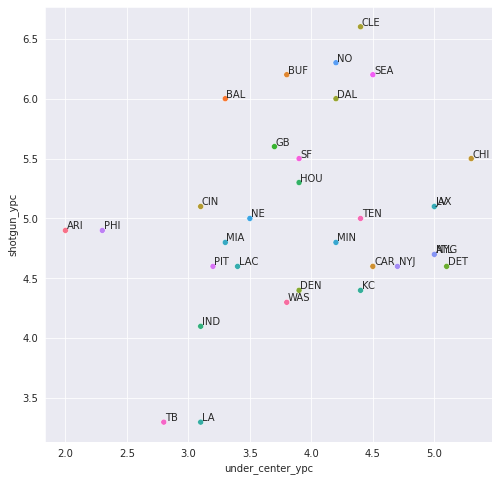

In [3]:
#get list of teams for labels
team_list = final_table['team']
#create scatterplot
plt.figure(figsize=(8,8))
new_plot = sns.scatterplot(data=final_table, x='under_center_ypc', y='shotgun_ypc', hue='team')
#get rid of legend because it's in the way
new_plot.legend_.remove()

#add labels 
for i in range(final_table.shape[0]):#shape[0] returns the number of rows because shape returns (x,y) so this is how you loop the same number as the rows
  plt.text(x=final_table.under_center_ypc[i]+0.01, y=final_table.shotgun_ypc[i]+0.01, s=final_table.team[i])#using indexing to pull data from each column from the right row

